Nice to haves:
- Deepdive into the factors each model focused on for predictions
- Investigation of how strong the presence of each group was for each algorithm 
- Evaluate precision and recall for each model
- Create a function that can take a song id, print the song id and print the 4 most similar songs with metrics 

# Recommenders

Here, I'll be comparing some machine learning for recommender models: SVD++ ('implicit' Single Value Decomposition), Non-Negative Matrix Factorization, Slope 1, Co Clustering and KNN with Z-score normalisation. 

After we see their initial scores, we'll try and make them as good as they can get and compare the results and accuracy.

Finally, we'll get some actual recommendations and see what we think of them.

In [61]:
# Replacement for time magic
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1 ms


## Imports

In [62]:
# General imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

time: 17 ms


In [63]:
# Surpise imports

from surprise import Dataset
from surprise import Reader

from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from surprise import SVDpp, NMF, SlopeOne, CoClustering, KNNWithZScore

from surprise import accuracy

time: 2 ms


## Constants

In [64]:
FILENAME = r".\Data\user_song_data.csv"

USED_ROWS = 200000
VALIDATION_SIZE = 50000
SUBSET_SIZE = 20000

CV_ITERS = 10

CUSTOM_COLOURS = ['#ff7675', '#74b9ff', '#BFA588',
                  '#4B3A51', '#ea8685', '#E7CA6B',
                 '#C2AF46', '#ff4757', '#00d8d6']

time: 1e+03 µs


# Data Setup

In [65]:
# Make experiment repeatable by setting random seed
from numpy.random import seed
seed(888)

# Creation of the dataframe, subsetting, small training, large training and validation data
data = pd.read_csv(FILENAME, index_col = 0).sample(frac=1)
data_used  = data[:USED_ROWS]
small_train_df = data_used[:SUBSET_SIZE]
train_df = data_used[SUBSET_SIZE:-1*(VALIDATION_SIZE)]
validation_df = data_used[-1*(VALIDATION_SIZE):]

print('Shape of the entire table \t|', data.shape)
print('Shape of used data        \t|', data_used.shape)
print('\n')
print('Shape of small train data \t|', small_train_df.shape)
print('Shape of full train data       \t|', train_df.shape)
print('Shape of validation data \t|', validation_df.shape)

C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Shape of the entire table 	| (2000000, 6)
Shape of used data        	| (200000, 6)


Shape of small train data 	| (20000, 6)
Shape of full train data       	| (130000, 6)
Shape of validation data 	| (50000, 6)
time: 4.8 s


Here the $2,000,000$ instances in our table have been split up into smaller subsets, used to test models for speed, a training set, to actually train out model, and a validation set, which we will use to validate our trained models.

### Data exploration

We won't spend much time on this because the data isn't really the focus here (and it might not help my agenda)

In [66]:
data.head()

,user_id,song_id,listen_count,release,year,song
1117846,25cdf9a7bf943a9b8f490cc372f20480c60ad264,SOTVMLE12AB018168E,17,Troubadour,2009,Wavin' Flag - K'Naan
910829,bae36981766ff05a687843b930e215e5ddfca8f3,SOKMXEQ12A6D4F6AA8,10,Sing-A-Longs & Lullabies For The Film Curious ...,2006,Talk Of The Town - Jack Johnson / Kawika Kahiapo
739401,f0ffa425818d635188835d9cad0684dd4ac4acdb,SOQNOAF12A8151AB86,1,Jonas Brothers,2007,When You Look Me In The Eyes - Jonas Brothers
85445,b1b0e0f9635c6fa5458bacd18b141563fba3eb0d,SOOWMGK12AF72A2D70,1,Comfort y Música Para Volar,0,Entre Canibales - Soda Stereo
630445,5dea8c2584ad9ad7b2abb316c6c13396fba96dac,SOSCIZP12AB0181D2F,3,The Fame Monster,2009,Alejandro - Lady GaGa


time: 17 ms


In [67]:
small_train_df.tail()

,user_id,song_id,listen_count,release,year,song
1212357,dc0cda93ff64a8cb9bc21d6deb9d7da4cbd4fa53,SOQLUTQ12A8AE48037,2,Echoes_ Silence_ Patience & Grace,2007,The Pretender - Foo Fighters
1943327,e8e710c638fcdd4a5c9e39dadab8aaafbf4ae132,SOLECSJ12A6D4F6243,1,Mary Ann meets the Gravediggers and other shor...,2002,Consequence Of Sounds - Regina Spektor
22539,63336e6e694361f57b6cae9f67bf5d793f86e1fb,SOIIOUS12A8AE47E20,7,Confessions,2007,Yeah! - Usher Featuring Lil' Jon & Ludacris
1403983,07a4d80048d3a3119c4c34d14fbe1a16e873b88a,SODMKPS12AB017E5C8,2,The Sound Of Goodbye,2001,The Sound of Goodbye - Armin van Buuren
724951,515822a6ce3266cc597501669741a5b273d74cf2,SOFFQBG12A6D4F9793,4,La Camisa Negra,2004,La Camisa Negra - Juanes


time: 12 ms


In [68]:
data.columns

Index(['user_id', 'song_id', 'listen_count', 'release', 'year', 'song'], dtype='object')

time: 3 ms


'Listen count' is the proxy for a users preference here; the higher it is, the better we assume the user rates the song. It'll form the basis of the analysis. Let's look at the listen count distribution.

In [69]:
round(data.listen_count.describe())

count    2000000.0
mean           3.0
std            7.0
min            1.0
25%            1.0
50%            1.0
75%            3.0
max         2213.0
Name: listen_count, dtype: float64

time: 71 ms


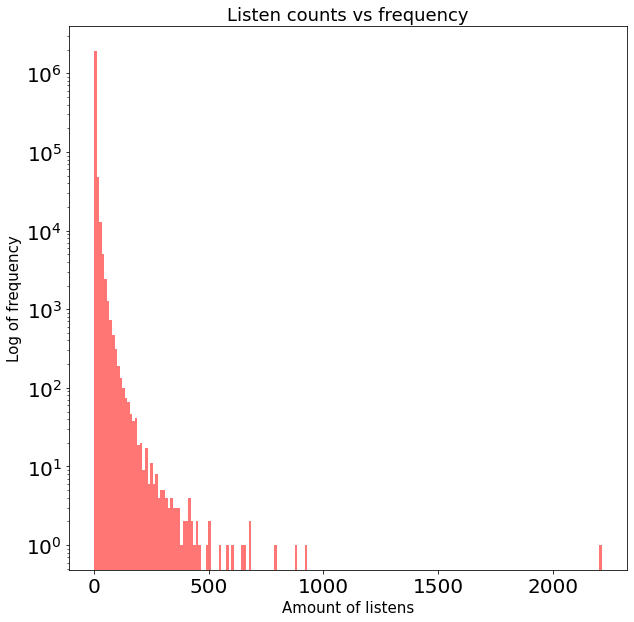

time: 1.31 s


In [70]:
fig = plt.figure(figsize=(10,10))
plt.hist(data.listen_count.astype(int), bins = 200,
         color=CUSTOM_COLOURS[0], log=True)
plt.title('Listen counts vs frequency', fontsize=18)
plt.ylabel('Log of frequency', fontsize = 15)
plt.xlabel('Amount of listens', fontsize=15)
plt.show()

This distribution is very heavily weighted toward the low end; 75% of our 2 million users have listened to a song 3 times or less, with the largest amount of listens being 2213. Lets look at the low and high ends sperately.

#### Looking at the listen counts

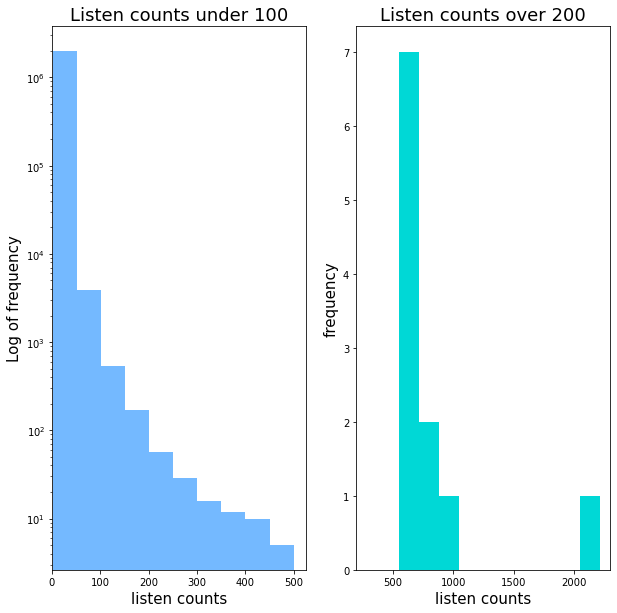

time: 976 ms


In [71]:
# Setup the figure
fig = plt.figure(figsize=(10,10), dpi=None)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.tight_layout(pad = 20)

# Listen counts below 200
plt.subplot(1,2,1)
plt.hist(data.listen_count[data.listen_count <= 500], bins = None,
         color = CUSTOM_COLOURS[1], log=True)
plt.xlim(0)
plt.title('Listen counts under 100', fontsize=18)
plt.xlabel('listen counts', fontsize=15)
plt.ylabel('Log of frequency', fontsize=15)


# Listen counts above 200
plt.subplot(1,2,2)
plt.hist(data.listen_count[data.listen_count > 500], bins = None,
        color=CUSTOM_COLOURS[8], log=False)
plt.xlim(200)
plt.title('Listen counts over 200', fontsize=18)
plt.xlabel('listen counts', fontsize=15)
plt.ylabel('frequency', fontsize=15)


plt.show()

It's interesting to see comparitive distributions for both ends of the distribution; the steep decline 

### Investigating popularity

In [72]:
# Gets the top 10 most popular of a specified attribute by listen count

def get_top_10(df, metric):
    
    """
    Gets the highest 10 rated items of a given metric
    
    Args:
        df: Dataframe to be evalauted
        metric: Ihe metric for dataframe to be evaluated over
        
    Returns:
        A dataframe of 10 records consisting of the top 10 attributes by listen count
    """
    frame = df.groupby(metric)
    frame = frame.sum()
    if metric != 'year':
        frame.drop('year', axis = 1, inplace=True)
        
    frame = frame.sort_values(by=['listen_count'],ascending=False)

        
    return frame[:10]

time: 998 µs


In [73]:
song_df = get_top_10(data,'song')
era_df = get_top_10(data, 'year').drop(0, axis = 0)
release_df = get_top_10(data, 'release')

time: 2.88 s


In [74]:
era_df

,listen_count
year,
2009,543523
2008,477714
2007,441634
2006,368215
2005,311379
2003,286301
2004,214543
2001,213894
2002,209490


time: 7 ms


In [75]:
song_df

,listen_count
song,
You're The One - Dwight Yoakam,54136
Undo - Björk,49253
Revelry - Kings Of Leon,41418
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) - Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner,31153
Sehr kosmisch - Harmonia,31036
Dog Days Are Over (Radio Edit) - Florence + The Machine,26663
Secrets - OneRepublic,22100
Canada - Five Iron Frenzy,21019
Invalid - Tub Ring,19645


time: 8 ms


In [76]:
release_df

,listen_count
release,
If There Was A Way,54136
Vespertine Live,49652
Only By The Night,46811
Greatest Hits,45360
My Worlds,38094
Waking Up,33902
Now That's What I Call Music! 75,32380
Save Me_ San Francisco,31865
Mozart - Eine kleine Nachtmusik,31153


time: 7 ms


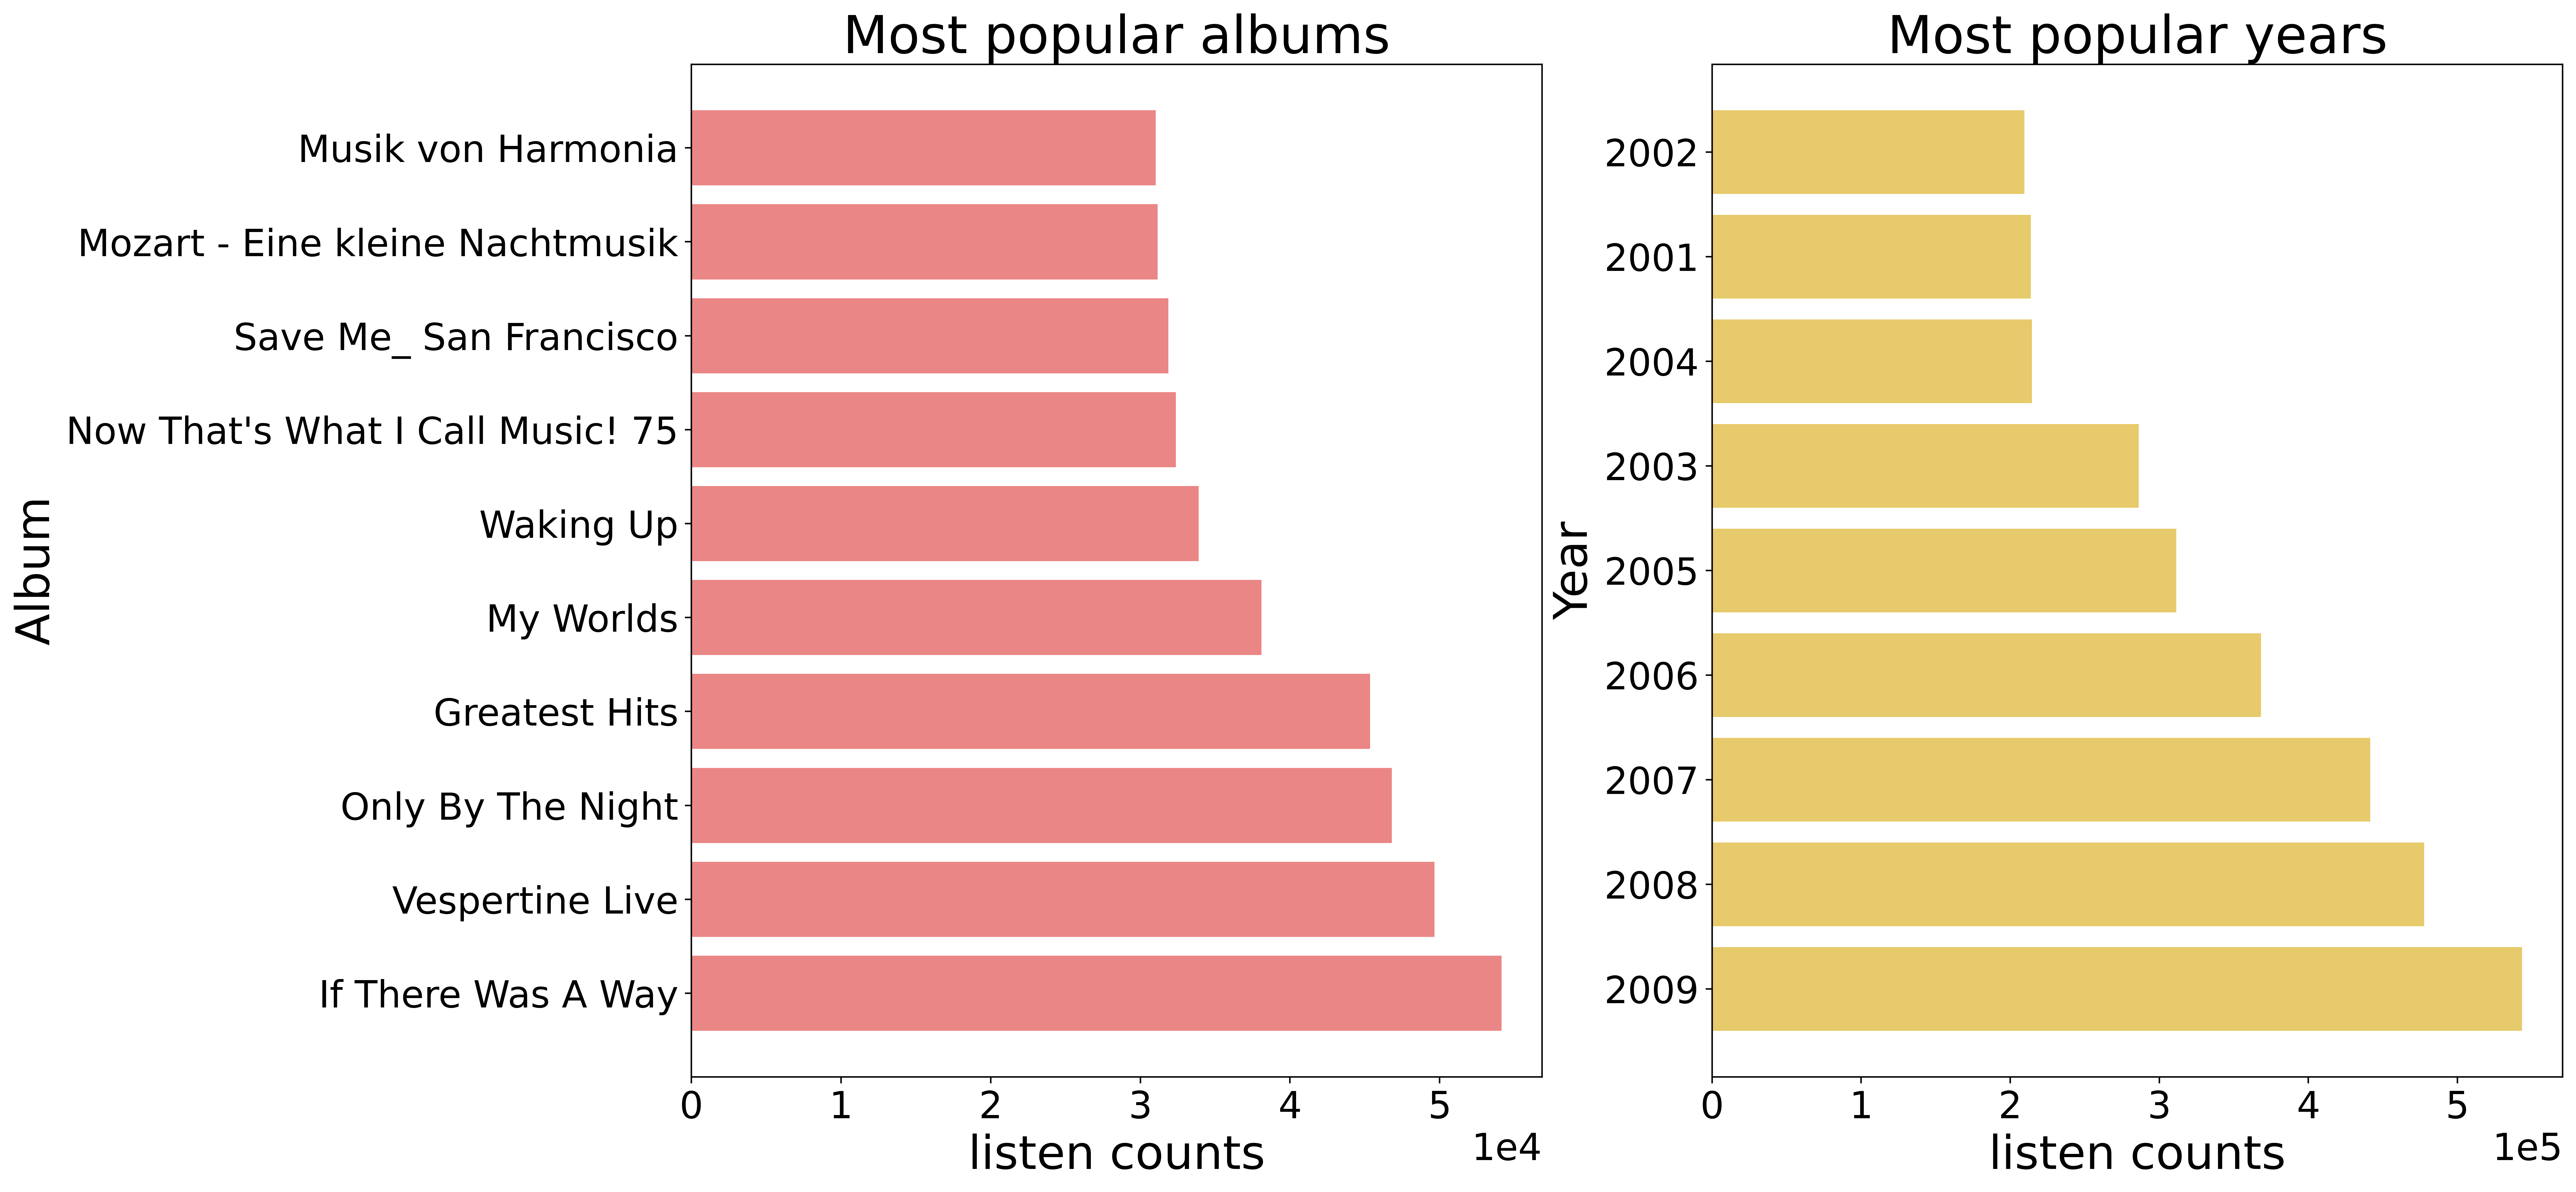

time: 3.39 s


In [77]:
# set up figure
plt.figure(figsize=(18,10), dpi = 500)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.tight_layout(pad = 8)

# Plot bar charts
plt.subplot(1,2,1)
plt.barh(release_df.index, release_df.listen_count, color = CUSTOM_COLOURS[4])
plt.xlabel('listen counts', fontsize=25)
plt.ylabel('Album', fontsize=25)
plt.title('Most popular albums', fontsize = 28)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



plt.subplot(1,2,2)
plt.barh(era_df.index.astype(str), era_df.listen_count, color = CUSTOM_COLOURS[5])
plt.xlabel('listen counts', fontsize=25)
plt.ylabel('Year', fontsize=25)
plt.title('Most popular years', fontsize = 28)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


plt.show()

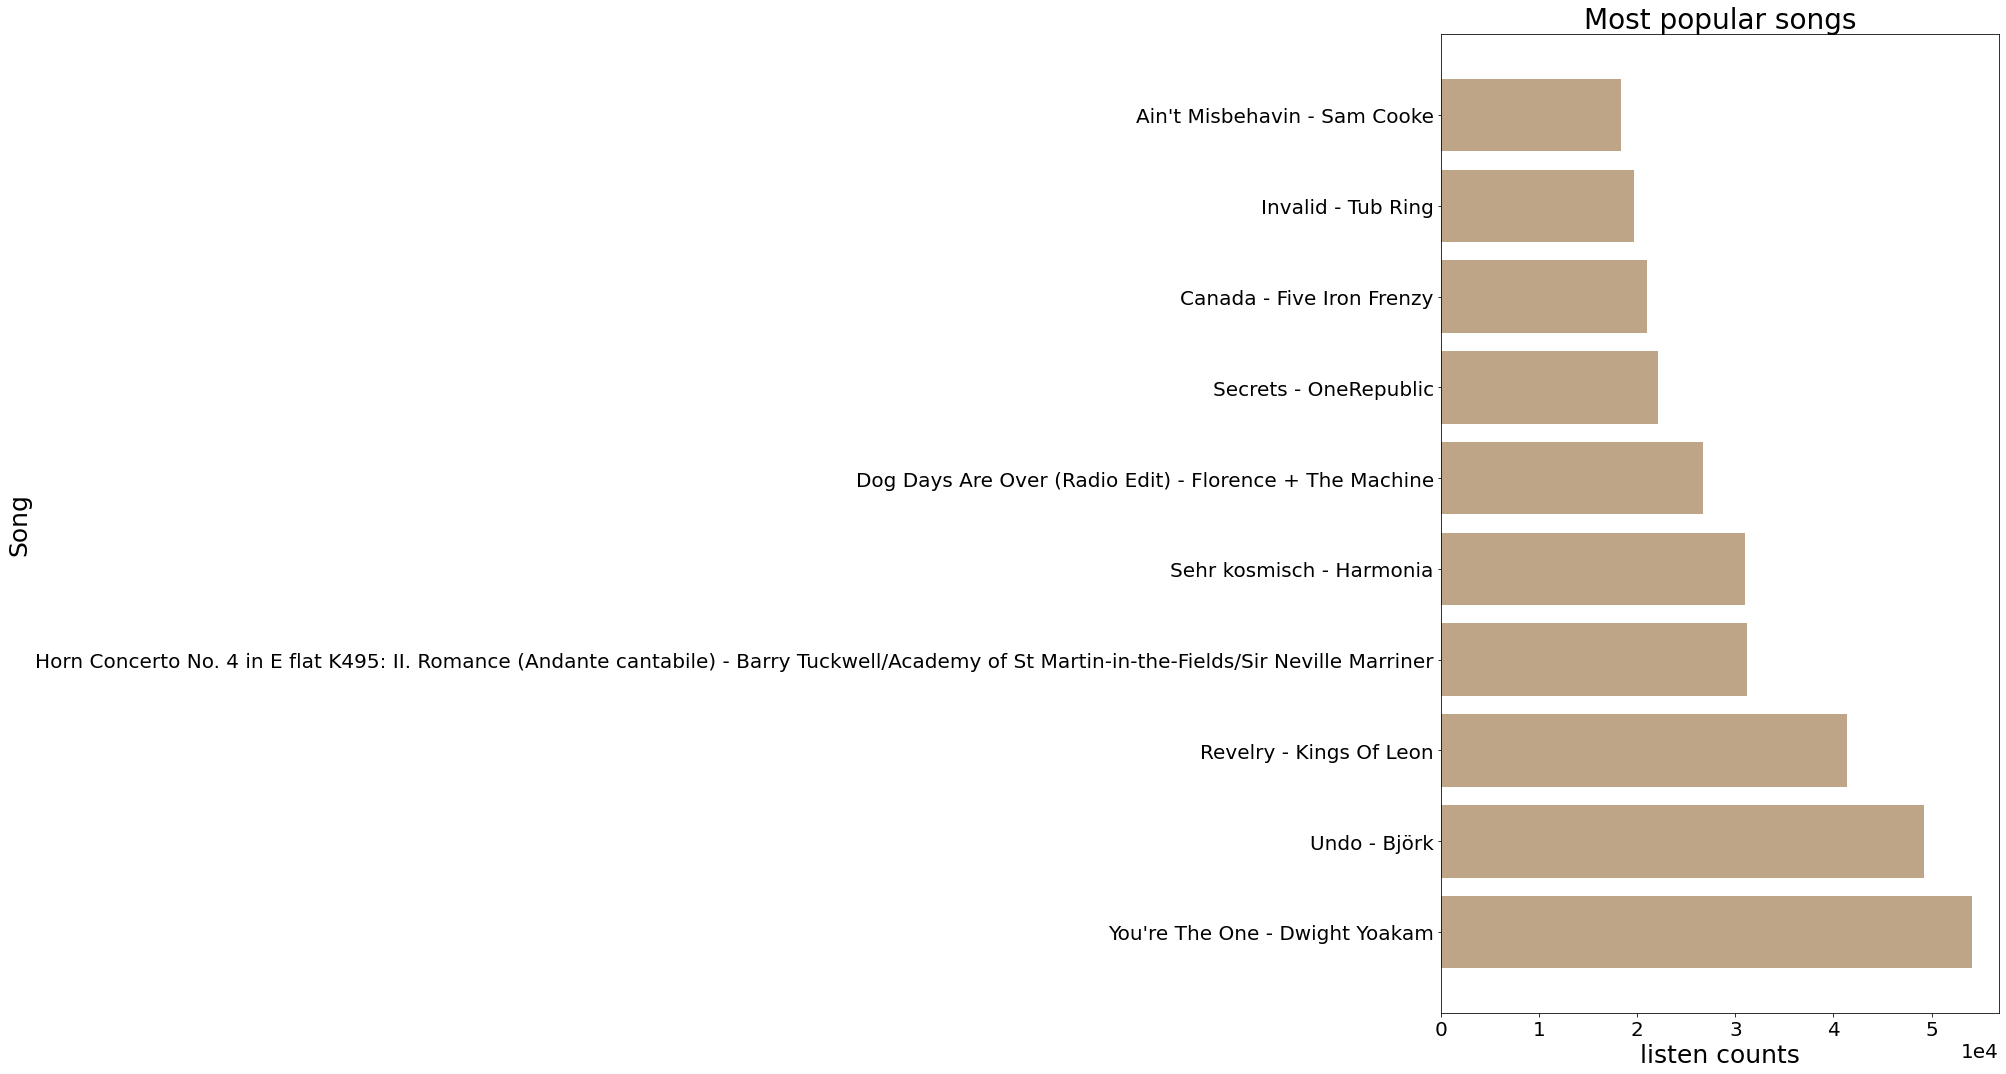

time: 397 ms


In [78]:
plt.figure(figsize=(10,18))

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.barh(song_df.index, song_df.listen_count, color = CUSTOM_COLOURS[2])
plt.xlabel('listen counts', fontsize=25)
plt.ylabel('Song', fontsize=25)
plt.title('Most popular songs',  fontsize = 28)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

Not surprisingly, the noughties had a good turn out here (2009 was the era for all the greats in my opinion). Secrets should be higher up but oh well. Now on to the easy part.

# Suprise recommenders

## How suprise recommendations work



## Prepare data for Surprise Recommender

Scikit-learn Surprise needs data in a specific format provided through Reader, which defines the ratings scale, and Dataset, which provides a way to interate through the data in steps instead of all at once.

In [79]:
lowest_rating = small_train_df.listen_count.min()
hightest_rating = small_train_df.listen_count.max()

time: 1 ms


In [80]:
reader = Reader(rating_scale=(lowest_rating, hightest_rating))

time: 1e+03 µs


In [81]:
# The columns must correspond to user id, item id and ratings (in that order)
small_surprise = Dataset.load_from_df(small_train_df[['user_id', 'song_id', 'listen_count']], reader)
trainset, testset = train_test_split(small_surprise)

time: 138 ms


## Implement some models

Next we can define the models. To evaluate these models we use Mean Squared Error and Root Mean Sqaured Error respectively, and define some helper functions.

In [82]:
# Getting the models
def get_models():
    
    """
    Gets specified models from Surprise predictions package
    
    """
    models = {'NMF': NMF(),
              'KNN with Z Score': KNNWithZScore(verbose=False),
              'SVD++': SVDpp(),
              'Slope 1': SlopeOne(),
             'Co Clustering': CoClustering()}
    
    return models

time: 1 ms


In [83]:
def run_model(model, data):
    
    """
    Helper function for computing model scores.
    
    Args:
        model: model to for scores to be computed for
        data: data for model to be ran on
        
    Returns:
        the mean rmse and mae for the model being evaluated
    
    """
    results = cross_validate(model, data, cv=5, verbose=False)
    
    mean_rmse = np.mean(results['test_rmse'])
    mean_mae = np.mean(results['test_mae'])
    
    yield mean_rmse, mean_mae
    
    
        
    

time: 1 ms


In [84]:
def scores_list_to_df(scores):
    """
    Takes a list and turns it into a sorted dataframe through a dict
    in an intermediate step.
    
    Args:
        scores: List of scores with models attributed to them

    Returns:
        A dataframe sorted by MAE abd RMSE
    
    """
    score_dict= dict((key,d[key]) for d in scores for key in d)
    score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['RMSE', 'MAE'])
    
    return score_df.sort_values(by=['MAE', 'RMSE'])
    

time: 999 µs


In [85]:
models = get_models()

model_scores = []

for model in models:
    print(model)
    algo = models[model]
    rmse, mae = next(run_model(algo,small_surprise))
    print(f'Root Mean Squared Error: {rmse.round(2)}, Mean Absolute Error: {mae.round(2)}, \n')
    
    scores = {model:[rmse, mae]}
    model_scores.append(scores)
    
    
model_scores_df = scores_list_to_df(model_scores)

NMF
Root Mean Squared Error: 6.59, Mean Absolute Error: 2.53, 

KNN with Z Score
Root Mean Squared Error: 6.82, Mean Absolute Error: 2.67, 

SVD++
Root Mean Squared Error: 164.7, Mean Absolute Error: 112.09, 

Slope 1
Root Mean Squared Error: 6.75, Mean Absolute Error: 2.65, 

Co Clustering
Root Mean Squared Error: 11.58, Mean Absolute Error: 3.61, 

time: 1min 29s


Could be a lot worse for a first pass (though not for SVD++, that's shocking), but we'll do better. We can use GridSearch to optimise our models. 

According to the docs, the current baselines parameters for each model tend to yeild the biggest bang for their buck, so we'll focus on the similarity paramters, which are more problem specific. We'll see which of the approaches to computing similarity work best for our models.

These are the rankings as it stands.

In [86]:
model_scores_df

,RMSE,MAE
NMF,6.593037,2.525353
Slope 1,6.745848,2.650441
KNN with Z Score,6.817433,2.673644
Co Clustering,11.583180,3.606400
SVD++,164.698754,112.090561


time: 9 ms


# Using Grid Search to optimise paramters

I started off by using combinatorial grid search for parameter optimization, but after using random grid search, I saw it took a fraction of the time and achieved similar quality results (and it's cheaper than getting a better computer).

Each of the models have their own separate parameters, and they need to be tuned differently. So, we'll take the models one by one.

The optimum parameters for the mean absolute error may differ from those for the root mean squared error. In this case, we'll take the one that shows the biggest improvement upon comparison.

In [87]:
tuned_model_scores = []

time: 2 ms


## Implicit Single Value Decomposition (SVD++)

Single Value Decomposition is the most well-known of these algorithms, owing its popularity to Netflix's million dollar competition and [Simon Funk's winning entry](https://sifter.org/~simon/journal/20061211.htm). Thank you, Simon.


According to the docs, the equation used to predict rating $\hat{r}_{ui}$ (a rating r from user u for item i) is:


$$\hat{r}_{ui} = \mu + b_u + b_i + q_{i}^{T}p_u $$

where $\mu$ is the mean rating, $b_u$ is a bias term for the user, $b_i$ is a bias term for the item, $q_i$ are the factors for the item (transposed) and $p_u$ are the factors for the user (both in matrix form). 

In the classic SVD, no account is made for the fact when a user makes a prediction for the item, a positive relationship between the user and the item is implied, regardless of the rating value. SVD++ makes a correction for this, namely:

$$ q_{i}^{T}p_u = q_{i}^{T} \left( p_u + |I|^{1/2}\sum_{{j\epsilon}I_u}{y_j} \right)  $$

where $y_j$ is a term taking implicit factors into account and $I_u$ is a scaling term for the user factors (I think, it doesn't say in the docs). 

The idea behind SVD and all matrix factorization is as the name suggests: describe the large, complicated matrix (data table) using smaller, simpler matrices, and from there infer values in the larger matrix using observed patterns in the smaller matrices.

This means that this is a regression problem, which will involve minimizing the loss, which is most often done using stochastic gradient descent. The docs suggest doing this by changing the regularization term and the learning rate. The number of factors will make a difference, as that will determine how many of the user’s other ratings are considered with a prediction.

First we'll create a grid of paramters to optimise...

In [88]:
SVDpp_params_grid = {'lr_all': list(np.linspace(0,0.01, 5)),
                    'reg_all': list(np.linspace(0, 0.1, 5)),
                    'n_factors': [5,10,15,20,25]
                    }

time: 3 ms


Then we'll create and fit the grid search object...

In [89]:
%%time
SVDpp_gs = RandomizedSearchCV(SVDpp, SVDpp_params_grid,
                              cv = 5, n_jobs=-1, n_iter = CV_ITERS)
SVDpp_gs.fit(small_surprise)

Wall time: 1min 3s
time: 1min 3s


Then we'll have a look at how we did and what the best parameters are.

In [90]:
# Improvements
print('Improvement in RSME after tuning:',
      ((model_scores_df.RMSE['SVD++'] - SVDpp_gs.best_score['rmse'])*100/ SVDpp_gs.best_score['rmse']).round(2),'%')
      
print('Improvement in MAE after tuning:',
     ((model_scores_df.MAE['SVD++'] - SVDpp_gs.best_score['mae'])*100/ SVDpp_gs.best_score['mae']).round(2),'%')

Improvement in RSME after tuning: 2435.02 %
Improvement in MAE after tuning: 4123.52 %
time: 2 ms


In [91]:
# combination of parameters that gave the best RMSE and MAE score
print('Best parameters for optimizing RMSE with SVD++ \t|', SVDpp_gs.best_params['rmse'],'\n')
print('Best parameters for optimizing MAE with SVD++ \t|', SVDpp_gs.best_params['mae'])

SVDpp_scores = {'SVD++' :[SVDpp_gs.best_score['rmse'], SVDpp_gs.best_score['mae']]}
tuned_model_scores.append(SVDpp_scores)

Best parameters for optimizing RMSE with SVD++ 	| {'lr_all': 0.0025, 'reg_all': 0.07500000000000001, 'n_factors': 15} 

Best parameters for optimizing MAE with SVD++ 	| {'lr_all': 0.0025, 'reg_all': 0.07500000000000001, 'n_factors': 15}
time: 2 ms


This is a dramatic improvement! The default parameters for SVD++ almost definetely overfit the data, as we can tell from the lower values for both the learning rates and the regularization terms. This find may affect other models as well.

## Non-Negative Matrix Factorization (NMF)



In Non-Negative Matrix Factorization, the factors that are derived from the original data matrix are <b> kept positive </b>. In SVD and other factorization/dimension reductionist methods can have 'negative factors', which (at least, for this application) have no real meaning. NMF can't, making the buckets it puts the data into much more intuitive. Mathematically, a prediction of rating $r_{ui}$ from user $u$ and item $i$ is expressed as:

$$\hat{r}_{ui} = q_i^{T}p_u$$

where $q_i^{T}$ is the item X factors matrix and $p_u$ is the user X factors matrix. Optimisation is done via SDG, and both the user and item matrices are updated by a formula I won't show here (read the [docs](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) for more info).

Like SVD++, the regularization terms are important in the optimization step, and the factors paramter determines how many latent features we want to try and find. This algorithm is also highly sensitive to initial values from which factors are initialized, but we won't change those here as those results turned out to be extremely unstable.

First we create a grid of parameters to optimize...

In [92]:
# params

NMF_params_grid = {'reg_qi': list(np.linspace(0,0.01, 10)),
                    'reg_pu': list(np.linspace(0, 0.1, 10)),
                    'n_factors': [5,10,15,20,25],
                    }


time: 2 ms


Then we create and fit the grid search object...

In [93]:
NMF_gs = RandomizedSearchCV(NMF, NMF_params_grid,
                            cv=5, n_jobs=-1, joblib_verbose=0, n_iter = CV_ITERS)
NMF_gs.fit(small_surprise)

time: 1min 28s


Then we see how we much we improved and what our best paremters were.

In [94]:
# Improvements
print('Improvement in RSME after tuning:',
      ((model_scores_df.RMSE['NMF'] - NMF_gs.best_score['rmse'])*100/ NMF_gs.best_score['rmse']).round(2),'%')
      
print('Improvement in Mean Absolute error after tuning:',
     ((model_scores_df.MAE['NMF'] - NMF_gs.best_score['mae'])*100/ NMF_gs.best_score['mae']).round(2),'%')

Improvement in RSME after tuning: 1.18 %
Improvement in Mean Absolute error after tuning: 0.92 %
time: 2 ms


In [95]:
# combination of parameters that gave the best RMSE and MAE score
print('Best parameters for optimizing RMSE with NMF \t|', NMF_gs.best_params['rmse'],'\n')
print('Best parameters for optimizing MAE with NMF \t|', NMF_gs.best_params['mae'])

NMF_scores = {'NMF' : [NMF_gs.best_score['rmse'], NMF_gs.best_score['mae']]}
tuned_model_scores.append(NMF_scores)

Best parameters for optimizing RMSE with NMF 	| {'reg_qi': 0.003333333333333333, 'reg_pu': 0.1, 'n_factors': 15} 

Best parameters for optimizing MAE with NMF 	| {'reg_qi': 0.0077777777777777776, 'reg_pu': 0.07777777777777778, 'n_factors': 5}
time: 8 ms


The amount of factors found to be best is less than the default of 20 (more pronounced here, especially for MAE). This implies overfitting for the defaults with this algorithm as well. The GridSearch didn't help at all here and the reasons are unclear (optimization barrier? simply not fit for this dataset?).

### K Nearest Neighbours with Z score normalisation (KNN)

The K nearest-neighbours algorithm is a tried and tested pattern recognition technique, spreading all the points in the data in n-dimensional space into their relevant groups. The prediction is based upon which group the new data point is closest to.

Using standard score (or z score) normalisation, we normalise the distances between each point in the dimension space and our prediction by scaling the similarity measure with $\sigma_u$ or $\sigma_i$, based on the average ratings either of the user or the item, depending on the parameter settings.

The similarity measure determines which points we say are in the group, and the user_based parameter does too. min_support is the number of points that need to be in a group for them to have a similarity measure computed, measuring their strength as a group. K is the maximum number of neighbours the new data point can have to be considered part of a group.

You know the drill by now...

In [96]:
# pramams

KNN_params_grid = {'k': [35,40,45],
                   'sim_options':
                   {'name':['cosine', 'msd', 'pearson', 'pearson_baseline'],
                    'user_based': [True,False],
                    'min_support':list(np.linspace(1,4,4))
                   }
            
         }

time: 3 ms


In [97]:
KNN_gs = RandomizedSearchCV(KNNWithZScore, KNN_params_grid,
                            cv=2, n_jobs=-1, joblib_verbose=0, n_iter = CV_ITERS)
KNN_gs.fit(small_surprise)

time: 29 s


In [98]:
# Improvements
print('Improvement in RSME after tuning:',
      ((model_scores_df.RMSE['KNN with Z Score'] - KNN_gs.best_score['rmse'])*100/ KNN_gs.best_score['rmse']).round(2),'%')
      
print('Improvement in Mean Absolute error after tuning:',
     ((model_scores_df.MAE['KNN with Z Score'] - KNN_gs.best_score['mae'])*100 / KNN_gs.best_score['mae']).round(2),'%')

Improvement in RSME after tuning: 1.13 %
Improvement in Mean Absolute error after tuning: 0.02 %
time: 2 ms


In [99]:
# combination of parameters that gave the best RMSE and MAE score
print('Best parameters for optimizing RMSE with KNN with Z Score \t|', KNN_gs.best_params['rmse'],'\n')
print('Best parameters for optimizing MAE with KNN with Z score \t|', KNN_gs.best_params['mae'])

KNN_scores = {'KNN with Z Score':[KNN_gs.best_score['rmse'], KNN_gs.best_score['mae']]}
tuned_model_scores.append(KNN_scores)

Best parameters for optimizing RMSE with KNN with Z Score 	| {'k': 35, 'sim_options': {'name': 'cosine', 'user_based': False, 'min_support': 3.0}} 

Best parameters for optimizing MAE with KNN with Z score 	| {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True, 'min_support': 3.0}}
time: 2 ms


Surprisingly, the pearson_baseline is not the most effective similarity measurement for this dataset as the docs suggested. The preference of a lowe min support again suggests there was overfitting here too, as a lower support implies that the groups that aren't that strongly tied together have significance here. Music isn't so easy to define, it seems.

### Slope 1

This algorithm computes predicted ratings purely based on the ratings of the user and the item being evaluated: no clusters, optimisation or regularization used here. This makes it simple, fast, and easily to calculate. And strangely, it wasn't half bad! It's simplicity seems to protect it from the overfitting problems we've been plagued with for the other models.

Since we have nothing to optimise, lets investigate some other accuracy metrics, like the Fraction of Concordant Pairs, or FCP.

Concordant Pairs are best explained as the pairs which 'travel in the same direction'. It makes the null hypothesis that as one pattern is observed in a certain direction with respect to one observer (i.e. if a user rates 1 song high, another higher, and another highest) then another user should follow suit, and if they do, this is a concordant pair. The FCP is the fraction of pairs which are concordant.
It basically calculates how well our algorithm's predictions follow the patterns in the data. A suitable explanation can be found [here](https://www.statisticshowto.com/concordant-pairs-discordant-pairs/).

In [100]:
algo = SlopeOne()
algo.fit(trainset)
accuracy.fcp(algo.test(testset))

FCP:  0.4660


0.4659863945578231

time: 1.19 s


About half of the predictions made with Slope 1 are concordant with the data. I'm not sure what a good fraction looks like, but given the size of our data it's not half bad (90% of it isn't being used for this experiment, mind you).

In [101]:
rmse, mae = next(run_model(SlopeOne(),small_surprise))

SlopeOne_scores = {'Slope One': [rmse,mae]}
tuned_model_scores.append(SlopeOne_scores)

time: 6.4 s


### Co Clustering

Co Clustering does what it says on the tin: clusters comparitive items (in our case, users and songs) in terms of their ratings. The average rating of the user and iterm clusters as well as the average ratings of the user-item clusters, is used to predict the rating of a user for a new item. [The docs](https://surprise.readthedocs.io/en/stable/co_clustering.html) provide a more thorough explanation, but it really is that simple. 

 Obviously, this depends on the number of user and item clusters present, so that's what we'll experiment with. 

In [102]:
# params
co_cluster_params = {'n_cltr_u':list(np.linspace(1,7,7,dtype=int)),
                    'n_cltr_i':list(np.linspace(1,7,7,dtype=int))}

time: 999 µs


In [103]:
co_cluster_gs = RandomizedSearchCV(CoClustering,
                                   co_cluster_params, cv=5, n_jobs=1, n_iter = CV_ITERS)
co_cluster_gs.fit(small_surprise)

time: 3min 18s


In [104]:
# Improvements
print('Improvement in RSME after tuning:',
      ((model_scores_df.RMSE['Co Clustering'] - co_cluster_gs.best_score['rmse'])*100 / co_cluster_gs.best_score['rmse']).round(3),'%')
      
print('Improvement in Mean Absolute error after tuning:',
     ((model_scores_df.MAE['Co Clustering'] - co_cluster_gs.best_score['mae']) *100/ co_cluster_gs.best_score['mae']).round(3),'%')

Improvement in RSME after tuning: 64.054 %
Improvement in Mean Absolute error after tuning: 28.928 %
time: 2 ms


In [105]:
# combination of parameters that gave the best RMSE and MAE score
print('Best parameters for optimizing RMSE with Co Clustering \t|', co_cluster_gs.best_params['rmse'])
print('Best parameters for optimizing MAE with Co Clustering \t|', co_cluster_gs.best_params['mae'])

co_cluster_scores = {'Co Clustering': [co_cluster_gs.best_score['rmse'], co_cluster_gs.best_score['mae']]}
tuned_model_scores.append(co_cluster_scores)

Best parameters for optimizing RMSE with Co Clustering 	| {'n_cltr_u': 1, 'n_cltr_i': 5}
Best parameters for optimizing MAE with Co Clustering 	| {'n_cltr_u': 1, 'n_cltr_i': 5}
time: 2 ms


Another improvement! Let's have a look at the how the stack up against each other now

#### New models league table

In [106]:
tuned_model_scores_df = scores_list_to_df(tuned_model_scores)

time: 4 ms


In [107]:
tuned_model_scores_df

,RMSE,MAE
NMF,6.516202,2.502241
SVD++,6.496939,2.653963
KNN with Z Score,6.741353,2.673235
Slope One,6.859395,2.681634
Co Clustering,7.060572,2.797229


time: 11 ms


# Evaluate tuning on total training dataset

## Prepare data

In [108]:
lowest_rating_XL = train_df.listen_count.min()
hightest_rating_XL = train_df.listen_count.max()

time: 2 ms


In [109]:
reader = Reader(rating_scale=(lowest_rating, hightest_rating))

time: 5 ms


In [110]:
# The columns must correspond to user id, item id and ratings (in that order).
large_surprise = Dataset.load_from_df(train_df[['user_id', 'song_id', 'listen_count']], reader)

time: 296 ms


## Evaluating the models

In [124]:
def get_tuned_models(measure='rmse'):
    models = {'Best NMF': NMF_gs.best_estimator[measure] ,
              'Best SVD++': SVDpp_gs.best_estimator[measure],
              'Best Slope 1': SlopeOne(),
              'Best Co Clustering': co_cluster_gs.best_estimator[measure],
              'Best KNN with Z score': KNN_gs.best_estimator[measure]
             }
    
    return models

time: 999 µs


In [125]:
# get models and scores list
tuned_models = get_tuned_models(measure = 'mae')
test_model_scores = []

# evaluate tuned models
for model in tuned_models:
    print(model)
    algo = tuned_models[model]
    try:
        rmse, mae = next(run_model(algo,large_surprise))
        print(f'Root Mean Squared Error: {rmse.round(2)}, Mean Absolute Error: {mae.round(2)}, \n')
        test_scores = {model:[rmse, mae]}
        test_model_scores.append(test_scores)
    except Exception as e:
        print(e)
    
# store model evaluations as dataframes    
test_model_scores_df = scores_list_to_df(test_model_scores)

Best NMF
Root Mean Squared Error: 7.13, Mean Absolute Error: 2.35, 

Best SVD++
Root Mean Squared Error: 298.8, Mean Absolute Error: 298.51, 

Best Slope 1
Root Mean Squared Error: 8.05, Mean Absolute Error: 2.74, 

Best Co Clustering
Root Mean Squared Error: 7.9, Mean Absolute Error: 2.77, 

Best KNN with Z score
Computing the msd similarity matrix...
Unable to allocate 15.0 GiB for an array with shape (44858, 44858) and data type float64
time: 9min 20s


In [126]:
test_model_scores_df

,RMSE,MAE
Best NMF,7.127918,2.351643
Best Slope 1,8.053535,2.737530
Best Co Clustering,7.895202,2.769075
Best SVD++,298.797644,298.514149


time: 12 ms


# Making predictions

We'll take the algorithms and use them to generate real recommendations based on the validation data. As users, we'll be a better judge of success than any statistical measure.

## Prepare validation data

Here's what we'll do:
   1. Load the validation data
   2. Separate users and songs by thier IDs
   3. Pair up songs with their song ids and delete repeating pairs to decrease redundancy
   4. Generate a random user
   5. Get the users most listened to songs and check them against the recommended songs

In [127]:
validation_surprise = Dataset.load_from_df(validation_df[['user_id', 'song_id', 'listen_count']], reader)

time: 147 ms


In [128]:
users = validation_df['user_id'].unique()

time: 36 ms


In [129]:
# make each song and song id pairing unique
song_id_pairs = validation_df[['song_id', 'song']].drop_duplicates()
song_id_pairs.index = song_id_pairs.song_id
song_id_pairs.drop('song_id', axis = 1, inplace = True)

time: 120 ms


In [130]:
song_id_pairs.head()

,song
song_id,
SODEIFT12AB0189E54,Paradise Circus (Gui Boratto Remix) - Massive ...
SOQUQQT12AF72A7BAE,Be (Intro) - Common
SOMGXHN12A58A7929F,But Tonight We Dance - Rise Against
SOFUNBK12A679C805B,Hand On Your Heart - José González
SOPFOEP12A6D4F6C3D,Runnin' - The Pharcyde


time: 11 ms


In [131]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


time: 1 ms


In [132]:
model_labels = list(test_model_scores_df.index)

time: 1 ms


In [133]:
random_user = users[random.randint(0,len(users))]
uid = random_user

user_top_songs = data[data['user_id'] == uid].sort_values(by=['listen_count'],
                                                           ascending = False)[:5].drop(['user_id',
                                                                                          'song_id'], axis = 1)
user_top_songs = user_top_songs[['song', 'release', 'year', 'listen_count']]
print(user_top_songs)
print('\n' * 3)
    
for label in model_labels:
    
    model = tuned_models[label]
    preds = model.test(validation_surprise.build_full_trainset().build_testset())
    top_n = get_top_n(preds, 10)
    print('\n'*2, 'Recommender model:', label,'\n')
    
    print('\n Recommended song(s): \n')
    for item in top_n[uid]:
        iid = item[0]
        rating = float(item[1])
        song = song_id_pairs.loc[iid][0]

        print (song)
        print (f'Predicted rating {rating:.3}','\n')
    
    

                                                      song  \
1044670                             The Small Print - Muse   
1044656                        The Want Ad - Pandora's Box   
1044666                           Encore Break - Pearl Jam   
1044657                             No Estaré Allí - Kudai   
1044658  Sweet Thing (Live Version) - Rufus And Chaka Khan   

                                      release  year  listen_count  
1044670                            Absolution     0             6  
1044656                          Original Sin     0             5  
1044666  Live At Benaroya Hall - Oct.22_ 2003  2009             5  
1044657                             Sobrevive  2006             4  
1044658                 Stompin' At The Savoy     0             4  






 Recommender model: Best NMF 


 Recommended song(s): 

Torn - Natalie Imbruglia
Predicted rating 1.04 



 Recommender model: Best Slope 1 


 Recommended song(s): 

Torn - Natalie Imbruglia
Predicted rating 2.0 

These aren't bad overall; I know most of the artists and this helped me find some new music I quite enjoy! The recommendations are similar from model to model, and having tested them out, they produce some bangers that match the vibe of the users top 10 songs. 

That said, a fair few run end up simply giving us songs that are already in the users top 5, which doesn't help much at all.

There's a _lot_ that hasn't been covered, and that which has isn't very detailed. Even so, a decent recommendation system has been created, that kind-of-basically works (not industry standard, but still).


# Conclusion

#### Comments

This data set is fairly large and sparse, with 2 million instances from many albums, users and years. That made dealing with this obviously tricky. The listen counts were heavily weighted toward the low end, which may mean the high end represented some outliers that would have been better omitted. Not much data processing was done this time round as the focus was on using and tuning the recommenders. In real life, processing this data would be the focus, and probably improve the results many times over.

#### Issues

The main issue with this is time at scale: for all 2 million instances, the run times for the implementation are around 15 minutes long, and it takes about 10 minutes to tune each model's parameters. After that, we get less than 3% improvement on 2 of the 4 trained models. One improves dramatically, and one gets a little worse. More tuning would clearly help a lot, but the resources and runtime don't allow for that. 

Decreasing the size of the data helped, and shuffling with a random seed set helped the results to be (roughly) reproducible, but not totally; the trends are the same (MAE and RMSE improve with each run for each algorithm bar NMF and the FCP for Slope 1 is about half) but the numbers are not exactly the same. It's not a big deal, so we'll ignore it.

#### Summary 

Here we have looked at a large, unstructured data set, got a sense of what's in it, had a look at some recommenders, kept track of their performance whilst tuning and using them, and finally gotten some predictions and given them the ultimate test: our own judgement.
The success of real recommenders isn't based on squared errors and other statistical tests, but whether the user listens to the song or watches the tv show (and then goes on to follow the artist/series). It may be worth collecting data on your listening habits via [Last FM's Scrobble API](https://www.last.fm/api/) and seeing if you could recommend some songs to yourself.